## Advance Data Science Innovation - Assignment 1 Second Submission

### NBA Career Prediction - Predicting 5-Year Career Longevity for NBA Rookies

**Group 1:** Nuwan Munasinghe, Wenying Wu, Nathan Fragar, Sean Williams, Carol Myhill

**Pre-requisites:**
- Create a github account (https://github.com/join)
- Install git (https://git-scm.com/book/en/v2/Getting-Started-Installing-Git)
- Install Docker (https://docs.docker.com/get-docker/)

The steps are:
1.   Launch Docker image
2.   Load and prepare data
3.   Model training and evaluation
     - neural net
     - logistic regression
4.   Xgboost training and evaluation
5.   Push changes

## 1. Load Python packages and libraries

In [1]:
# Only run this step once per Docker session - run then RESTART the Kernal & run this code again
!pip install imbalanced-learn

In [3]:
# required python libraries
import pandas as pd
import numpy as np
from joblib import dump
import seaborn as sns
import matplotlib.pyplot as plt
import time

# scikit-learn models and functions
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import accuracy_score

from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression

# Logistic Regression Models
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_confusion_matrix

import warnings
warnings.filterwarnings('ignore')

## 2. Prepare data for model training

**[2.1]** Import training & final test (kaggle) data

**[2.2]** Copy data for transformation for modelling steps

In [4]:
# import training & final test data
df_train = pd.read_csv('../data/raw/train.csv')
df_test = pd.read_csv('../data/raw/test.csv')

In [6]:
# Create a copy of df and save it into a variable called df_cleaned
df_cleaned = df_train.copy()
df_clean_test = df_test.copy()

# Drop columns 'Id'
drop_cols = ['Id']   

# We need to drop the Id column as this is irrelevant for modelling
df_cleaned.drop(drop_cols, axis=1, inplace=True)
df_clean_test.drop(drop_cols, axis=1, inplace=True)

# Remove leading and trailing space from the column names
df_cleaned.columns = df_cleaned.columns.str.strip()
df_clean_test.columns = df_clean_test.columns.str.strip()

# Extract the column TARGET_5Yrs and save it into variable called target
target = df_cleaned.pop('TARGET_5Yrs')

print('df_cleaned row,cols    ',df_cleaned.shape)
print('df_clean_test rows,cols',df_clean_test.shape,'\n')

# we will need labels later for plotting results
labels = df_cleaned.columns.tolist() 
print(labels)

df_cleaned row,cols     (8000, 19)
df_clean_test rows,cols (3799, 19) 

['GP', 'MIN', 'PTS', 'FGM', 'FGA', 'FG%', '3P Made', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV']


**[2.3]** Function to select required features only

**[2.4]** Create first train/test data with ALL features remaining for Baseline testing & evaluation

In [9]:
# only keep selected features / cols
def select_features(df_train, df_test, keep_cols=['']):
    # take copies of the Cleaned data up to now - so we can rerun from here different feature selections
    df_clean_new = df_train.copy()
    df_clean_new_test = df_test.copy()
    
    return df_clean_new[keep_cols], df_clean_new_test[keep_cols]


# ALL Features for baseline testing for training models
df_clean_R1, df_clean_R1_test = select_features(df_cleaned, df_clean_test,keep_cols=labels)

# check still the same number of rows & columns as original cleaned training data
print('df_clean_R1 row,cols    ',df_clean_R1.shape)

df_clean_R1 row,cols     (8000, 19)


### Standardising, Resampling Imbalance Data

**[2.5]** Create function to prepare training data for modelling
- apply Sci-kit Learn `StandardScaler` as the data contains negative values
- allow for resampling techniques to treat imbalanced target data `SMOTE`, `ADASYN` are the current techniques

(i) the Synthetic Minority Oversampling Technique (SMOTE) Sampling <br>
(ii) the Adaptive Synthetic (ADASYN) Sampling <br>
https://imbalanced-learn.org/stable/over_sampling.html#smote-adasyn

In [13]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, ADASYN

# set defaults
random_state=100
scaler = StandardScaler()

# Prepare training data for modelling - Standardising, Resampling for imbalanced data
def Prep_Model_Data(df_clean, target, scaler, resample='', random_state=8):
    
    # rescale eg: scaler = StandardScaler()
    df_clean = scaler.fit_transform(df_clean)
    # df_clean_test = scaler.fit_transform(df_clean_test)

    #---------------------------------------------------------------------------------------
    # Split randomly the dataset with random_state=8 into 2 different sets: data (80%) and test (20%)
    X_data, X_test, y_data, y_test = train_test_split(df_clean, target, test_size=0.2, random_state=random_state)

    # Split the remaining data (80%) randomly with random_state=8 into 2 different sets: training (80%) and validation (20%)
    X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=random_state) 
    
    #---------------------------------------------------------------------------------------
    # RESAMPLE if indicated
    
    # Original Training data
    if resample=='NO RESAMPLE' or resample=='':
        X_train_res, y_train_res = X_train, y_train
        X_val_res, y_val_res =  X_val, y_val
        X_test_res, y_test_res =  X_test, y_test
        print('NO Resample - ALL Features')
    
    # SMOTE - treat Imbalanced Target data after splitting Training & Test & Validation data
    if resample=='SMOTE':
        X_train_res, y_train_res = SMOTE(random_state=random_state).fit_resample(X_train, y_train)
        X_val_res, y_val_res = SMOTE(random_state=random_state).fit_resample(X_val, y_val)
        X_test_res, y_test_res = SMOTE(random_state=random_state).fit_resample(X_test, y_test)

    # ADASYN - treat Imbalanced Target data after splitting Training & Test & Validation data
    if resample=='ADASYN':
        X_train_res, y_train_res = ADASYN(random_state=random_state).fit_resample(X_train, y_train)
        X_val_res, y_val_res = ADASYN(random_state=random_state).fit_resample(X_val, y_val)
        X_test_res, y_test_res = ADASYN(random_state=random_state).fit_resample(X_test, y_test)
        
    return X_train_res, y_train_res, X_val_res, y_val_res, X_test_res, y_test_res


## 3. Model Training and Evaluation

**[3.1]** Function to perform **Classification** training and basic evaluation

In [14]:
from sklearn.metrics import roc_auc_score, make_scorer

def Train_Classifier(X_train_res, y_train_res, X_val_res, y_val_res, X_test_res, y_test_res, classifier, features='all', resample='resample'):
    t_start = time.process_time()
    # fit model
    classify = classifier.fit(X_train_res, y_train_res)
    t_end = time.process_time()       
    t_diff = t_end - t_start

    #--------------------------------------------------------------------------
    # Compare accuracy of the given test data
    
    # baseline target average
    y_mode = y_train_res.mode()
    
    if resample=='NO RESAMPLE' or resample=='':
        y_base_res = np.full((len(y_train_res), 1), y_mode)
    else: 
        y_base_res = np.full((len(y_train_res), 1), y_mode[0])

    # for debugging during dev/test
    if 1==2:
        print('mode',y_train_res.mode(), '\ttype:',type(y_train_res.mode()))
        print('len(X_train)',len(X_train_res))
        print('len(y_train)',len(y_train_res))
        print('y_base_res',y_base_res)

    print(f"Compare accuracy between data sets - testing {features} features ")
    print(f"Classifier - {classify}")
    print(f"Imbalanced data fix - {resample}")
    print("Baseline:     ",accuracy_score(y_train_res, y_base_res))
    print("Train data:   ",classifier.score(X_train_res, y_train_res))
    print("Validation:   ",classifier.score(X_val_res, y_val_res))
         
    #--------------------------------------------------------------------------
    # final test (unseen) data AUC score
    pred_prob = classifier.predict_proba(X_test_res)
    auc_score = roc_auc_score(y_test_res, pred_prob[:,1])
    print('Test data auc:',auc_score,'\n')    
    
    return classify, X_train_res, y_train_res, X_val_res, y_val_res, X_test_res, y_test_res


**[3.2]** Functions to evaluate model accuracy and performance metrics

- AUC - area under the curve https://stats.stackexchange.com/questions/132777/what-does-auc-stand-for-and-what-is-it

In [57]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, plot_confusion_matrix
from sklearn.metrics import make_scorer

font_size=14
plt.rcParams['font.size'] = font_size

def Plot_Confusion_Matrix(classifier, X, y, title):
    print(f'Confusion matrix - {title}')
    plot_confusion_matrix(classifier, X, y, cmap=plt.cm.Blues, normalize='true')
    plt.show();


def Model_Perform_Evaluate(classifier, X_test, y_test, show_roc, class_label):
    # predict probabilities
    pred_prob = classifier.predict_proba(X_test)
    
    if show_roc==True:
        # roc curve for models
        fpr, tpr, thresh = roc_curve(y_test, pred_prob[:,1], pos_label=1)
        Plot_ROC_Curve(pred_prob, fpr, tpr, class_label)
    
    return pred_prob, class_label

    
def Plot_ROC_Curve(pred_prob, fpr, tpr, model_name):
    plt.style.use('seaborn')

    # roc curve for models
    # fpr, tpr, thresh = roc_curve(y_test, pred_prob[:,1], pos_label=1)

    # plot roc curves
    plt.plot(fpr, tpr, linestyle='--',color='orange', label=model_name)
    # plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
    
    # title
    plt.title(f'ROC curve - {model_name}', fontsize=font_size+2)
    # x label
    plt.xlabel('False Positive Rate', fontsize=font_size)
    # y label
    plt.ylabel('True Positive rate', fontsize=font_size)

    plt.legend(loc='best', fontsize=(font_size-2))
    plt.savefig('ROC',dpi=300)
    plt.show();    

**[3.3]** Save the model predictions on the Kaggle test data to CSV, then submit online to the Kaggle competition

https://www.kaggle.com/c/uts-advdsi-22-02-nba-career-prediction/leaderboard

In [76]:
#save the final "test" prediction probabilities for Kaggle

def Save_Kaggle_Results(classifier, scaler, df_clean_test, save_csv=False, csv_name=''):
    df_final_test = scaler.fit_transform(df_clean_test)
    y_final_preds = classifier.predict_proba(df_final_test)
    
    # combine df_test Id column with prediction probabilities column (cover to dataframe first) 
    frames = [df_test.iloc[:,0], pd.DataFrame(y_final_preds[:,1])]
    result = pd.concat(frames, axis=1) 
    result.columns = ['Id','tmp']
    result['TARGET_5Yrs'] = [round(num, 2) for num in result['tmp']]
    result.drop(['tmp'], axis=1, inplace=True)

    # print(len(df_final_test),len(y_final_preds))
    # print(result.shape)

    #--------------------------------------------------------------------------
    # Save the final predictions for submission to Kaggle
    if save_csv==True:
        result.to_csv('../data/processed/cazmayhem_{c}.csv'.format(c=csv_name), index=False)
        print('kaggle results saved ../data/processed/cazmayhem_{c}.csv'.format(c=csv_name))
    
    return csv_name

**[3.4]** Initialise Classification models & parameters

1. Neural Network MLPClassifier()
2. LogisticRegression()

These 2 models performed the best in Test 1.

In [17]:
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

# MLPClassifier parameters
activation='logistic'
solver='adam'     # sgd, adam (default)
alpha=0.01        # 0.0001 default
max_iter=300
batch_size=100    

random_state=100

# Classification Models defined - MLPClassifier()
clf_NN_MLP=MLPClassifier(activation=activation, solver=solver, alpha=alpha, batch_size=batch_size, random_state=random_state)

# Classification Models defined - LogisticRegression()
clf_LR=LogisticRegression(C=109.85411419875572, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100, n_jobs=None, penalty='l2',
          tol=0.0001, verbose=0, warm_start=False, random_state=random_state)

#### [3.5] TEST 1 - Neural Net (MLPClassifier) ALL Features with SMOTE resampling

Previous testing has been performed - these tests performed best for each model type

Compare accuracy between data sets - testing ALL features 
Classifier - MLPClassifier(activation='logistic', alpha=0.01, batch_size=100,
              random_state=100)
Imbalanced data fix - SMOTE
Baseline:      0.5
Train data:    0.6905541267243395
Validation:    0.6117924528301887
Test data auc: 0.7309956352749146 

Confusion matrix - training data


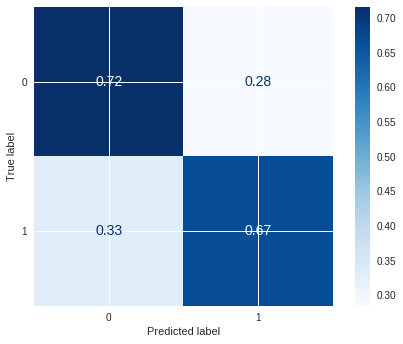

Confusion matrix - test data


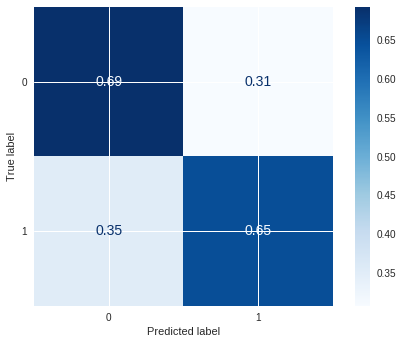

In [35]:
# Test 1 - Neural Net (MLPClassifier) Resampling Imbalance Data - ALL Original Features
random_state = 100
features='ALL'
resample='SMOTE'
model_name=f'Neural Net (MLPClassifier) {resample}'
# labels = keep all features
top_feat=labels 

classifier=clf_NN_MLP

# create train/test data from selected important features only
df_clean_mod, df_clean_mod_test = select_features(df_cleaned, df_clean_test, top_feat)

# Prepare data for model training
X_train_res, y_train_res, X_val_res, y_val_res, X_test_res, y_test_res = Prep_Model_Data(df_clean_mod, target, scaler, resample, random_state)

# Train the Classification model
classify, X_train_res, y_train_res, X_val_res, y_val_res, X_test_res, y_test_res = Train_Classifier(X_train_res, y_train_res, X_val_res, y_val_res, X_test_res, y_test_res, 
                                                                                                    classifier, features, resample)
# Confusion Matrix Training data
Plot_Confusion_Matrix(classify, X_train_res, y_train_res, 'training data')

# Confusion Matrix Testing data
Plot_Confusion_Matrix(classify, X_test_res, y_test_res, 'test data')

# Model predictions & roc_curve
pred_prob_1, model_name_1 = Model_Perform_Evaluate(classify, X_test_res, y_test_res, False, model_name)

# save results for Kaggle comp
Save_Kaggle_Results(classify, scaler, df_clean_mod_test, False, 'nn_mlp_smote')

#### [3.6] TEST 2 - Logistic Regression ALL Features with SMOTE resampling

Compare accuracy between data sets - testing ALL features 
Classifier - LogisticRegression(C=109.85411419875572, random_state=100)
Imbalanced data fix - SMOTE
Baseline:      0.5
Train data:    0.6605097030628946
Validation:    0.6216981132075472
Test data auc: 0.7301530133737341 

Confusion matrix - training data


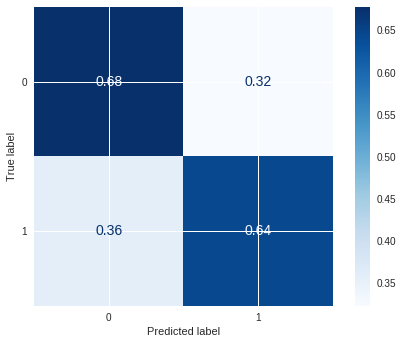

Confusion matrix - test data


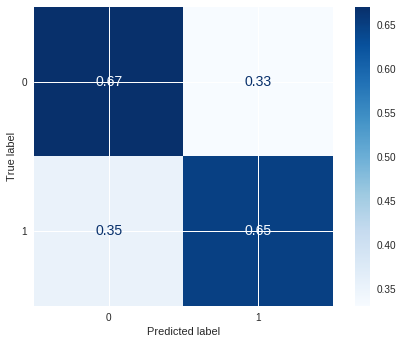

In [34]:
# Test 2 - Logistic Regression Resampling Imbalance Data - ALL Original Features
random_state = 100
features='ALL'
resample='SMOTE'
model_name=f'Logistic Regression {resample}'
csv_name='lr_smote'
# labels = keep all features
top_feat=labels 

classifier=clf_LR

# intiailse training data for this test
df_clean_mod, df_clean_mod_test = select_features(df_cleaned, df_clean_test, top_feat)
 
# X_train, y_train, X_val, y_val, X_test, y_test = Prep_Model_Data(df_clean_R1, df_clean_R1_test, target, scaler, classifier, features, model_name, random_state)
X_train_res, y_train_res, X_val_res, y_val_res, X_test_res, y_test_res = Prep_Model_Data(df_clean_mod, target, scaler, resample, random_state)

# run the final Train_Classifier()
classify, X_train_res, y_train_res, X_val_res, y_val_res, X_test_res, y_test_res = Train_Classifier(X_train_res, y_train_res, X_val_res, y_val_res, X_test_res, y_test_res, 
                                                                                                    classifier, features, resample)
# Confusion Matrix Training data
Plot_Confusion_Matrix(classify, X_train_res, y_train_res, 'training data')

# Confusion Matrix Testing data
Plot_Confusion_Matrix(classify, X_test_res, y_test_res, 'test data')

# Plot ROC Curve
pred_prob_2, model_name_2 = Model_Perform_Evaluate(classify, X_test_res, y_test_res, False, model_name)

# save results for Kaggle comp
Save_Kaggle_Results(classify, scaler, df_clean_mod_test, False, 'lr_smote')

#### [3.7] TEST 3 - Neural Net (MLPClassifier) Reduced Features with SMOTE resampling

- remove the %-age columns as they are a reflection of "made" / "attempts" for the various features

Compare accuracy between data sets - testing reduced features 
Classifier - MLPClassifier(activation='logistic', alpha=0.01, batch_size=100,
              random_state=100)
Imbalanced data fix - SMOTE
Baseline:      0.5
Train data:    0.6568856675239654
Validation:    0.6320754716981132
Test data auc: 0.7215221978735492 

Confusion matrix - training data


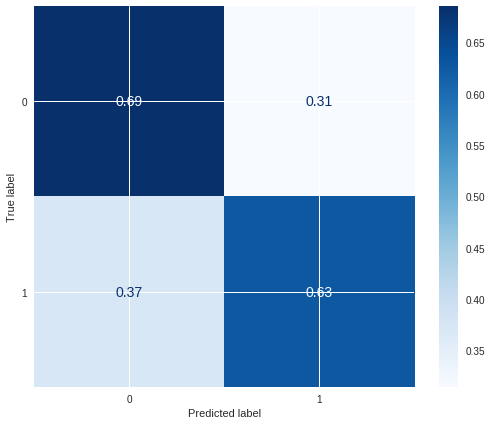

Confusion matrix - test data


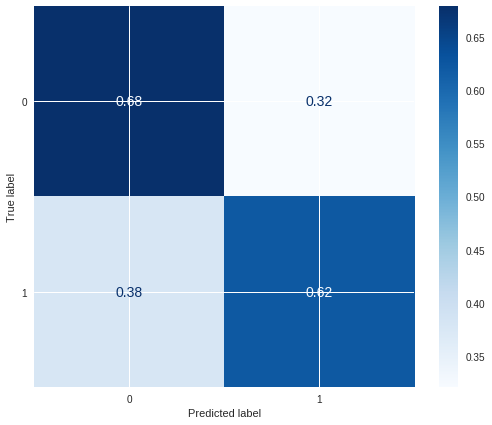

'mlp_smote_feat_2'

In [99]:
# Test 3 - Neural Net (MLPClassifier) Resampling Imbalance Data - Reduced Features
random_state = 100
features='reduced'
resample='SMOTE'
model_name=f'Neural Net (MLPClassifier) {resample}'
csv_name='mlp_smote_feat_2'
# remove %-age columns
top_feat=['GP', 'MIN', 'PTS', 'FGM', 'FGA', '3P Made', '3PA', 'FTM', 'FTA', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV']

classifier=clf_NN_MLP

# intiailse training data for this test
df_clean_mod, df_clean_mod_test = select_features(df_cleaned, df_clean_test, top_feat)
 
# Prepare data for model training
X_train_res, y_train_res, X_val_res, y_val_res, X_test_res, y_test_res = Prep_Model_Data(df_clean_mod, target, scaler, resample, random_state)

# Train the Classification model
classify, X_train_res, y_train_res, X_val_res, y_val_res, X_test_res, y_test_res = Train_Classifier(X_train_res, y_train_res, X_val_res, y_val_res, X_test_res, y_test_res, 
                                                                                                    classifier, features, resample)
# Confusion Matrix Training data
Plot_Confusion_Matrix(classify, X_train_res, y_train_res, 'training data')

# Confusion Matrix Testing data
Plot_Confusion_Matrix(classify, X_test_res, y_test_res, 'test data')

# Model predictions & roc_curve
Model_Perform_Evaluate(classify, X_test_res, y_test_res, False, model_name)

# save results for Kaggle comp
Save_Kaggle_Results(classify, scaler, df_clean_mod_test, False, csv_name)

#### [3.8] TEST 4 - Logistic Regression Reduced Features with SMOTE resampling

- remove the %-age columns as they are a reflection of "made" / "attempts" for the various features

Compare accuracy between data sets - testing reduced features 
Classifier - LogisticRegression(C=109.85411419875572, random_state=100)
Imbalanced data fix - SMOTE
Baseline:      0.5
Train data:    0.6585223287350946
Validation:    0.6268867924528302
Test data auc: 0.7243256770283798 

Confusion matrix - training data


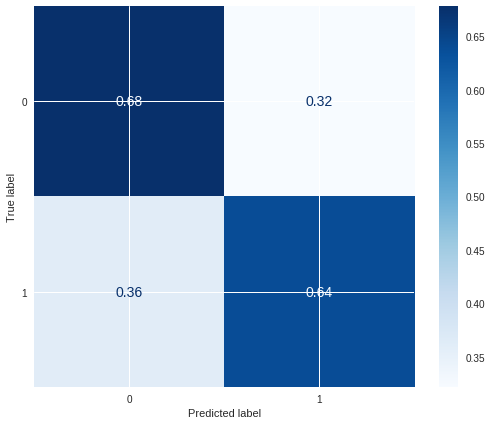

Confusion matrix - test data


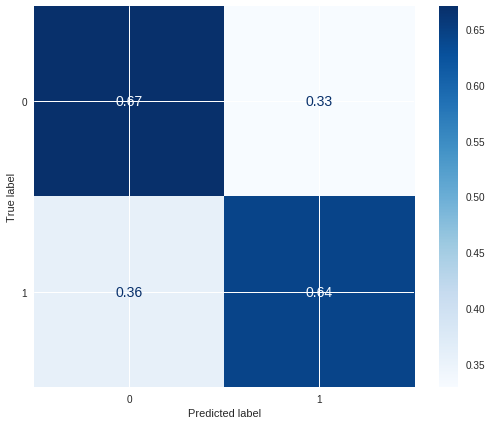

'lr_smote_feat_2'

In [103]:
# Test 4 - Logistic Regression Resampling Imbalance Data - Reduced Features
random_state = 100
features='reduced'
resample='SMOTE'
model_name=f'Logistic Regression {resample}'
csv_name='lr_smote_feat_2'
# remove %-age columns
top_feat=['GP', 'MIN', 'PTS', 'FGM', 'FGA', '3P Made', '3PA', 'FTM', 'FTA', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV']

classifier=clf_LR

# intiailse training data for this test
df_clean_mod, df_clean_mod_test = select_features(df_cleaned, df_clean_test, top_feat)
 
# Prepare data for model training
X_train_res, y_train_res, X_val_res, y_val_res, X_test_res, y_test_res = Prep_Model_Data(df_clean_mod, target, scaler, resample, random_state)

# Train the Classification model
classify, X_train_res, y_train_res, X_val_res, y_val_res, X_test_res, y_test_res = Train_Classifier(X_train_res, y_train_res, X_val_res, y_val_res, X_test_res, y_test_res, 
                                                                                                    classifier, features, resample)
# Confusion Matrix Training data
Plot_Confusion_Matrix(classify, X_train_res, y_train_res, 'training data')

# Confusion Matrix Testing data
Plot_Confusion_Matrix(classify, X_test_res, y_test_res, 'test data')

# Model predictions & roc_curve
Model_Perform_Evaluate(classify, X_test_res, y_test_res, False, model_name)

# save results for Kaggle comp
Save_Kaggle_Results(classify, scaler, df_clean_mod_test, False, csv_name)

## 4. Perform Gradient Boosting model training

**[4.1]** `Autoreload` extensions to refresh functions defined externally

**[4.2]** Reload `Autoreload` extension if already loaded

**[4.3]** Function to perform **Train_XGBoost** training and basic evaluation

In [37]:
%load_ext autoreload
%autoreload 2

In [38]:
%reload_ext autoreload

In [71]:
# Import the xgboost package as xgb
import xgboost as xgb
from src.models.performance import print_class_perf

def Train_XGBoost(xgboost, X_train, y_train, X_val, y_val, X_test, y_test):
    # Fit the model with the prepared data
    xgboost.fit(X_train, y_train)
    print('\n',xgboost.fit(X_train, y_train),'\n')

    # Import dump from joblib and save the fitted model into the folder models as a file called xgboost_default
    from joblib import dump 
    dump(xgboost,  '../models/xgboost_default.joblib')

    # Save the predictions from this model for the training and validation sets into 2 variables called y_train_preds and y_val_preds
    y_train_preds = xgboost.predict(X_train)
    y_val_preds = xgboost.predict(X_val)
    y_test_preds = xgboost.predict(X_test)
    
    # prediction probabilities for AUC
    y_train_pred_prob = xgboost.predict_proba(X_train)
    y_val_pred_prob = xgboost.predict_proba(X_val)
    y_test_pred_prob = xgboost.predict_proba(X_test)

    print_class_perf(y_preds=y_train_preds, y_actuals=y_train, y_pred_prob=y_train_pred_prob[:,1], set_name='Training', average='weighted')
    print_class_perf(y_preds=y_val_preds, y_actuals=y_val, y_pred_prob=y_val_pred_prob[:,1], set_name='Validation', average='weighted')    
    print_class_perf(y_preds=y_test_preds, y_actuals=y_test, y_pred_prob=y_test_pred_prob[:,1], set_name='Test', average='weighted')
    
    return xgboost, xgboost


**[4.4]** Function to identify **feature importance** for xgboost trained data

- return the top N features by importance value

In [40]:
def xgb_feature_important(clf_xgb, df_clean, max_num_features=5):
    # Extract the feature importance from the trained xgboost model
    feat_imp = clf_xgb.get_booster().get_score(importance_type="gain")

    # Using a dictionary comprehension, create a dictionary called mapper with keys 
    # in the format of f0 (0 is the index of the first column) and values as column names
    mapper = {'f{0}'.format(i): v for i, v in enumerate(df_clean.columns)}

    # Using a dictionary comprehension, create a dictionary called mapping with keys 
    # as the column names from mapper and values as the corresponding feature importance
    mapping = {mapper[k]: v for k, v in feat_imp.items()}

    # Plot the partial dependence plot using plot_importance for the top 5 features
    xgb.plot_importance(mapping, max_num_features=max_num_features)
    
    # extract top 5 features - but this will be an array
    n_feat = max_num_features
    top_feat = pd.DataFrame(sorted(mapping.items(), key=lambda x: x[1], reverse=True)).iloc[:n_feat,:1].values

    # Convert elements in a numpy array to string
    top_feat = [",".join(item) for item in top_feat.astype(str)]
    print('\n')
    print('Top features list',top_feat)
    
    return top_feat

**[4.5]** **TEST 5** - XGBoost training with default parameters

In [43]:
# Test 5 - XGBoost Resampling Imbalance Data - ALL Original Features
random_state = 100
features='ALL'
resample='NO RESAMPLE'
model_name=f'XGBoost {resample}'
top_feat=labels

# intiailse training data for this test
df_clean_mod, df_clean_mod_test = select_features(df_cleaned, df_clean_test, top_feat)
 
# instantiate the XGBClassifier class into a variable called xgboost1
xgboost1 = xgb.XGBClassifier(learning_rate=0.01, random_state=random_state)

X_train_res, y_train_res, X_val_res, y_val_res, X_test_res, y_test_res = Prep_Model_Data(df_clean_mod, target, scaler, resample, random_state)

Train_XGBoost(xgboost1, X_train_res, y_train_res, X_val_res, y_val_res, X_test_res, y_test_res)

NO Resample - ALL Features

 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=100,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None) 

Accuracy Training: 0.85546875
F1       Training: 0.8059690786292248
AUC      Training: 0.812439484999491 

Accuracy Validation: 0.8265625
F1       Validation: 0.7605048802466723
AUC      Validation: 0.6698434819897083 

Accuracy Test: 0.8275
F1       Test: 0.7666689655172415
AUC      Test: 0.7006395387925239 



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=100,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

**[4.6]** Perform hyperparameter tuning with Hyperopt

- input parameters: hyperparameter seacrh space (`space`)
- logics: train a xgboost model with the search space and calculate the average accuracy score for cross validation with 10 folds
- output parameters: dictionary with the loss score and STATUS_OK

In [70]:
# Import Trials, STATUS_OK, tpe, hp, fmin from hyperopt package
from hyperopt import Trials, STATUS_OK, tpe, hp, fmin

# Define the search space for xgboost hyperparameters
space = {
    'max_depth' : hp.choice('max_depth', range(5, 20, 1)),
    'learning_rate' : hp.quniform('learning_rate', 0.01, 0.5, 0.05),
    'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1),
    'subsample' : hp.quniform('subsample', 0.1, 1, 0.05),
    'colsample_bytree' : hp.quniform('colsample_bytree', 0.1, 1.0, 0.05)
}

# Define a function called objective
def objective(space):
    from sklearn.model_selection import cross_val_score
    
    xgboost = xgb.XGBClassifier(
        max_depth = int(space['max_depth']),
        learning_rate = space['learning_rate'],
        min_child_weight = space['min_child_weight'],
        subsample = space['subsample'],
        colsample_bytree = space['colsample_bytree'],
        random_state=random_state
    )
    
    acc = cross_val_score(xgboost, X_train_res, y_train_res, cv=10, scoring="accuracy").mean()

    return{'loss': 1-acc, 'status': STATUS_OK }

**[4.7]** Launch Hyperopt search and save the result in a variable called `best`

In [47]:
# Launch Hyperopt search and save the result in a variable called `best`
best = fmin(
    fn=objective,   
    space=space, 
    algo=tpe.suggest,       
    max_evals=10
)

# Print the best set of hyperparameters
print("\nBest: ", best)

100%|██████████| 10/10 [00:17<00:00,  1.71s/trial, best loss: 0.16484374999999996]

Best:  {'colsample_bytree': 0.1, 'learning_rate': 0.1, 'max_depth': 14, 'min_child_weight': 9.0, 'subsample': 0.6000000000000001}


**[4.7]** Instantiate a XGBClassifier with best set of hyperparameters

**[4.8]** Fit the model with the prepared data

In [48]:
# Instantiate a XGBClassifier with best set of hyperparameters
xgboost2 = xgb.XGBClassifier(
    max_depth = best['max_depth'],
    learning_rate = best['learning_rate'],
    min_child_weight = best['min_child_weight'],
    subsample = best['subsample'],
    colsample_bytree = best['colsample_bytree'],
    random_state=random_state
)

# Fit the model with the prepared data
xgboost2.fit(X_train_res, y_train_res)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=14,
              min_child_weight=9.0, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=100,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.6000000000000001, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [49]:
# Display the accuracy and f1 scores of this baseline model on the training and validation sets
print_class_perf(y_preds=xgboost2.predict(X_train_res), y_actuals=y_train_res, y_pred_prob=xgboost2.predict_proba(X_train_res)[:,1], set_name='Training', average='weighted')
print_class_perf(y_preds=xgboost2.predict(X_val_res), y_actuals=y_val_res, y_pred_prob=xgboost2.predict_proba(X_val_res)[:,1], set_name='Validation', average='weighted')
print_class_perf(y_preds=xgboost2.predict(X_test_res), y_actuals=y_test_res, y_pred_prob=xgboost2.predict_proba(X_test_res)[:,1], set_name='Test', average='weighted')

# Test Accuracy Score 
# Test: 0.6852169333512617

Accuracy Training: 0.840625
F1       Training: 0.7761380234933606
AUC      Training: 0.7965357753727558 

Accuracy Validation: 0.828125
F1       Validation: 0.7613836094985268
AUC      Validation: 0.6354030874785591 

Accuracy Test: 0.8325
F1       Test: 0.7654242740392977
AUC      Test: 0.6852169333512617 



**[4.9]** **TEST 6** Perform XGBoost training using SMOTE resampling for imbalanced target data

- using best performing parameters from Hyperbot


 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=14,
              min_child_weight=9.0, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=100,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.6000000000000001, tree_method='exact',
              validate_parameters=1, verbosity=None) 

Accuracy Training: 0.9098667290156652
F1       Training: 0.9092573196175017
AUC      Training: 0.9636902181189039 

Accuracy Validation: 0.8830188679245283
F1       Validation: 0.8820309982758792
AUC      Validation: 0.9187655749377002 

Accuracy Test: 0.8933933933933934
F1       Test: 0.8927009970075591
AUC      Test: 0.9286273886499112 



Top features list ['3P Made', 'BLK', 'OR

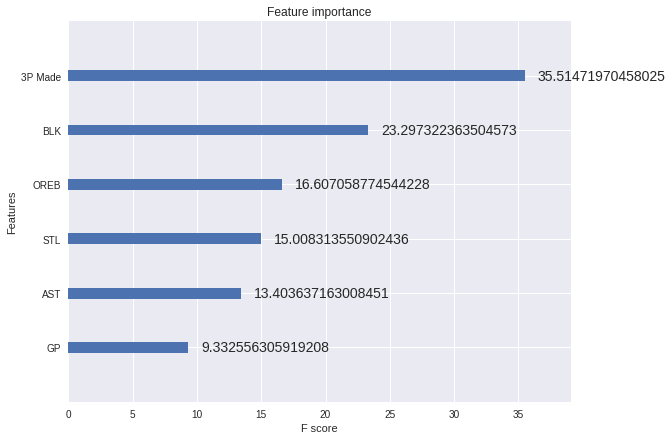

In [104]:
# Test 6 - XGBoost Hyperparameter Tuned - Resampling Imbalance Data - ALL Original Features
features='ALL'
resample='SMOTE'
scaler = StandardScaler()
max_num_features=6
# labels = ALL original features
top_feat=labels

# select required features for this tesm
df_clean_mod, df_clean_mod_test = select_features(df_cleaned, df_clean_test, top_feat)
 
# intiailse training data for this test
X_train_res, y_train_res, X_val_res, y_val_res, X_test_res, y_test_res = Prep_Model_Data(df_clean_mod, target, scaler, resample, random_state)

# use xgboost2 with best parameters from Hyperbot
classify, clf_xgb_1 = Train_XGBoost(xgboost2, X_train_res, y_train_res, X_val_res, y_val_res, X_test_res, y_test_res)

# New Test AUC Score 
# Test: 0.9286273886499112

# Show XGB feature importance
top_feat = xgb_feature_important(classify, df_clean_mod, max_num_features)

**[4.10]** **TEST 7** Repeat previous step with only top N features identified as most important

- still using xgboost2

df_clean_mod rows,copls (8000, 16)
X_train_res rows,copls  (8554, 16)

 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=14,
              min_child_weight=9.0, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=100,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.6000000000000001, tree_method='exact',
              validate_parameters=1, verbosity=None) 

Accuracy Training: 0.9055412672433949
F1       Training: 0.9048482821997781
AUC      Training: 0.9584482446550211 

Accuracy Validation: 0.8882075471698113
F1       Validation: 0.8871314739514387
AUC      Validation: 0.9192653079387683 

Accuracy Test: 0.8948948948948949
F1       Test: 0.8940203445930087
AUC     

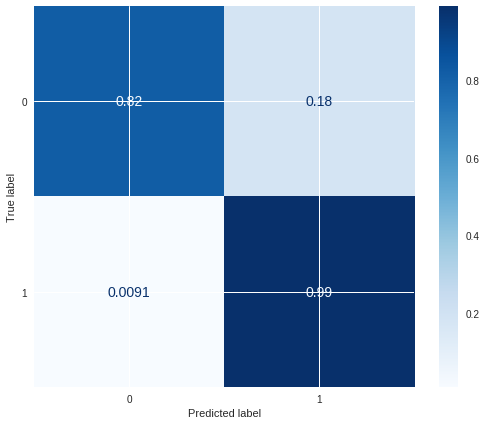

Confusion matrix - test data


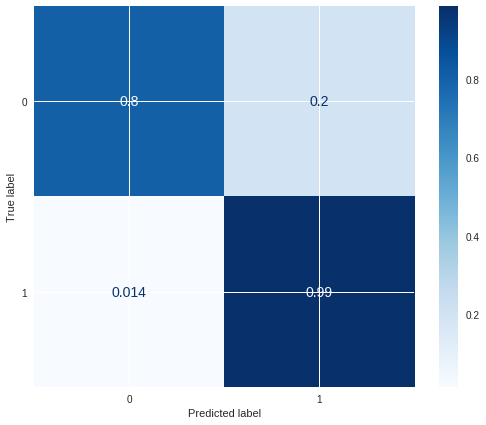

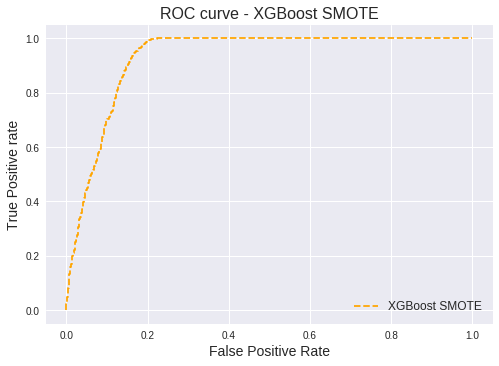

kaggle results saved ../data/processed/cazmayhem_xgboost_smote_top_feat.csv


In [101]:
# TEST 7 XGBoost repeat previous step with only top N features identified as most important
features='Top 5 Important'
resample='SMOTE'
model_name=f'XGBoost {resample}'
csv_name='xgboost_smote_top_feat'
# features identified previous step
top_feat=top_feat

scaler = StandardScaler()

# select required features for this tesm
df_clean_mod, df_clean_mod_test = select_features(df_cleaned, df_clean_test, top_feat)
 
# intiailse training data for this test
X_train_res, y_train_res, X_val_res, y_val_res, X_test_res, y_test_res = Prep_Model_Data(df_clean_mod, target, scaler, resample, random_state)

# quick check we have the same features selected in training data
print('df_clean_mod rows,copls',df_clean_mod.shape)
print('X_train_res rows,copls ',X_train_res.shape)

# Train the model using xgboost2 after hyperopt
classify, clf_xgb_2 = Train_XGBoost(xgboost2, X_train_res, y_train_res, X_val_res, y_val_res, X_test_res, y_test_res)

# Confusion Matrix Training data
Plot_Confusion_Matrix(classify, X_train_res, y_train_res, 'training data')

# Confusion Matrix Testing data
Plot_Confusion_Matrix(classify, X_test_res, y_test_res, 'test data')

# Plot ROC Curve - save pret_prob & model_name for combined ROC graph
pred_prob_3, model_name_3 = Model_Perform_Evaluate(classify, X_test_res, y_test_res, True, model_name)

# save results for Kaggle comp - XGBoost with hyperopt using SMOTE for imbalanced target - correct model this time
best_mod_xgb = Save_Kaggle_Results(classify, scaler, df_clean_mod_test, True, csv_name)

# Show XGB feature importance - not required this step
# xgb_feature_important(classify, df_clean_mod, max_num_features=5)

# Test AUC Score
# Test: 0.9336216847478108

In [81]:
def Save_Kaggle_Results_test(classifier, scaler, df_clean_test, save_csv=False, csv_name=''):
    df_final_test = scaler.fit_transform(df_clean_test)
    y_final_preds = classifier.predict_proba(df_final_test)
    
    # combine df_test Id column with prediction probabilities column (cover to dataframe first) 
    frames = [df_test.iloc[:,0], pd.DataFrame(y_final_preds[:,1])]
    result = pd.concat(frames, axis=1) 
    result.columns = ['Id','tmp']
    result['TARGET_5Yrs'] = [round(num, 2) for num in result['tmp']]
    result.drop(['tmp'], axis=1, inplace=True)

    # print(len(df_final_test),len(y_final_preds))
    # print(result.shape)

    #--------------------------------------------------------------------------
    # Save the final predictions for submission to Kaggle
    if save_csv==True:
        result.to_csv('../data/processed/cazmayhem_{c}.csv'.format(c=csv_name), index=False)
        print('kaggle results saved ../data/processed/cazmayhem_{c}.csv'.format(c=csv_name))
    
    return csv_name

df_clean_mod_test.shape

(3799, 5)

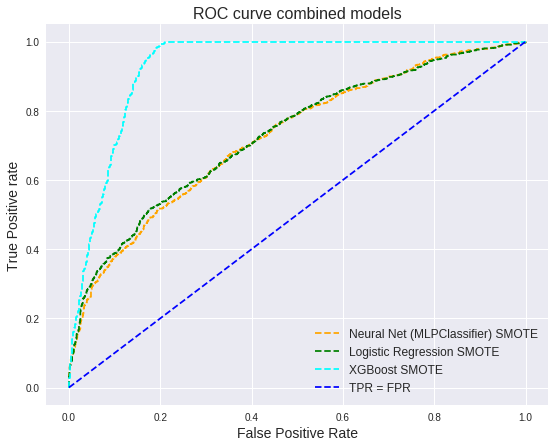

In [102]:
#=========================================================================
# COMBINE ROC CURVE GRAPH
#=========================================================================

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test_res, pred_prob_1[:,1], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test_res, pred_prob_2[:,1], pos_label=1)
fpr3, tpr3, thresh3 = roc_curve(y_test_res, pred_prob_3[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test_res))]
p_fpr, p_tpr, _ = roc_curve(y_test_res, random_probs, pos_label=1)

# chart size
plt.rcParams["figure.figsize"] = (9,7) 

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label=model_name_1)
plt.plot(fpr2, tpr2, linestyle='--',color='green', label=model_name_2)
plt.plot(fpr3, tpr3, linestyle='--',color='cyan', label=model_name_3)
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue', label='TPR = FPR')

# title
plt.title(f'ROC curve combined models', fontsize=font_size+2)
# x label
plt.xlabel('False Positive Rate', fontsize=font_size)
# y label
plt.ylabel('True Positive rate', fontsize=font_size)

plt.legend(loc='best', fontsize=(font_size-2))
plt.savefig('ROC',dpi=300)
plt.show();    

**[4.11]** Save the best fitted model into the folder 'models'


In [91]:
#--------------------------------------------------------------------------
# Save the best fitted model into the folder 'models', named for each classifier

dump(clf_xgb_2,  '../models/{c}.joblib'.format(c=best_mod_xgb))

['../models/xgboost_smote_top_feat.joblib']

## 5. Push changes to GitHub

In [ ]:
"""
# Add you changes to git staging area
# Create the snapshot of your repository and add a description
# Push your snapshot to Github

git add .   
git commit -m "commit 4 xgboost hyperopt"
git push https://*********@github.com/CazMayhem/adv_dsi_AT1.git

# Check out to the master branch
# Pull the latest updates

git checkout master
git pull https://*********@github.com/CazMayhem/adv_dsi_AT1.git

# Check out to the data_prep branch
# Merge the master branch and push your changes
git checkout xgboost_hyperopt
git merge master
git push https://*********@github.com/CazMayhem/adv_dsi_AT1.git

"""